In [1]:
import numpy as np
from numpy import ma
import pandas as pd
import math
from sklearn import metrics, linear_model
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
import sklearn
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

import tensorflow as tf
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import os
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import average_precision_score, matthews_corrcoef
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Import Data

In [2]:
print(os.getcwd())
relative_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
data = pd.read_csv(relative_path+'/preprocessed_data/non_split_dataset_OHE/total_subset.csv')
data = data.drop(['evil'],axis=1)
print(data.shape)

a:\Desktop\FYP Final Files\notebooks\Unsupervised_ML
(1141078, 14)


In [3]:
data.head(1)

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,System_Core,Amazon_AWS,Container_Virtualization,Maintenance_Package_Management,Security_Monitoring,Utility_Misc,sus
0,1,0,0,1,157,5,0,1,0,0,0,0,0,1


In [4]:
X = data
y = data['sus']

In [5]:
X.head(1)

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,System_Core,Amazon_AWS,Container_Virtualization,Maintenance_Package_Management,Security_Monitoring,Utility_Misc,sus
0,1,0,0,1,157,5,0,1,0,0,0,0,0,1


In [6]:
y.head(1)

0    1
Name: sus, dtype: int64

# Helpers

In [7]:
def print_metrics(y_true, y_predicted):

    accuracy = accuracy_score(y_true, y_predicted)   
    metrics_results = precision_recall_fscore_support(y_true, y_predicted, average="weighted", pos_label=1)
    average_precision = average_precision_score(y_true, y_predicted)
    balanced_accuracy = balanced_accuracy_score(y_true, y_predicted)
    mcc = matthews_corrcoef(y_true, y_predicted)
    
    print(f'Accuracy:\t{accuracy:.3f}')
    print(f'Precision:\t{metrics_results[0]}')
    print(f'Recall:\t\t{metrics_results[1]:.3f}')
    print(f'F1-Score:\t{metrics_results[2]:.3f}')
    print("Average Precision Score:", average_precision)
    print("Balanced Accuracy Score:", balanced_accuracy)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_true , y_predicted)))
    
    #make confusion matrix
    confusion_matrixs = confusion_matrix(y_true, y_predicted)
    

    TP = confusion_matrixs[1][1]
    TN = confusion_matrixs[0][0]
    FP = confusion_matrixs[0][1]
    FN = confusion_matrixs[1][0]


    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrixs, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

    # Print roc curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predicted)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, )
    display.plot()
    plt.show()


    # Assuming test_df_labels is your true labels and mse_test contains continuous score values
    precision, recall, _ = precision_recall_curve(y_true, y_predicted)

    # Calculate the area under the curve
    pr_auc = auc(recall, precision)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

In [8]:
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def fraud_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

In [9]:
def prepare_labels(y_predicted):
    """
    Helper function to help map out the outputs from models that return -1 for outliers and 1 for inliners.
    """
    y_predicted[y_predicted == 1] = 0
    y_predicted[y_predicted == -1] = 1
    return y_predicted

# Split data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)

In [11]:
X_train.shape

(912862, 14)

In [12]:
X_train = X_train[X_train['sus']==0]
X_train = X_train.drop(columns='sus')
X_test = X_test.drop(columns='sus')

In [13]:
X_train.shape

(774175, 13)

In [14]:
X_train.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,System_Core,Amazon_AWS,Container_Virtualization,Maintenance_Package_Management,Security_Monitoring,Utility_Misc
335256,1,1,0,0,1005,4,0,0,0,0,0,0,1
1043942,1,1,0,0,1005,4,0,0,0,0,0,0,1
1028670,1,1,0,1,5,2,0,1,0,0,0,0,0
674605,1,1,0,0,3,1,0,0,0,0,0,1,0
714299,1,1,0,0,1005,4,0,0,0,0,0,1,0


# Model training

## Isolation forest

In [15]:
iforest = IsolationForest(random_state=0,contamination=0.05)
iforest.fit(X_train)

IsolationForest(contamination=0.05, random_state=0)

In [16]:
ypred_iforest = iforest.predict(X_test)
ypred_iforest = prepare_labels(ypred_iforest)
print(classification_report(y_test, ypred_iforest,digits=3))

              precision    recall  f1-score   support

           0      0.841     0.951     0.893    193389
           1      0.015     0.004     0.007     34827

    accuracy                          0.807    228216
   macro avg      0.428     0.478     0.450    228216
weighted avg      0.715     0.807     0.758    228216



Accuracy:	0.807
Precision:	0.7152866122438194
Recall:		0.807
F1-Score:	0.758
Average Precision Score: 0.1520257840115302
Balanced Accuracy Score: 0.4776131747373912
Matthews Correlation Coefficient (MCC): -0.08012068008463517
AUC : 0.47761


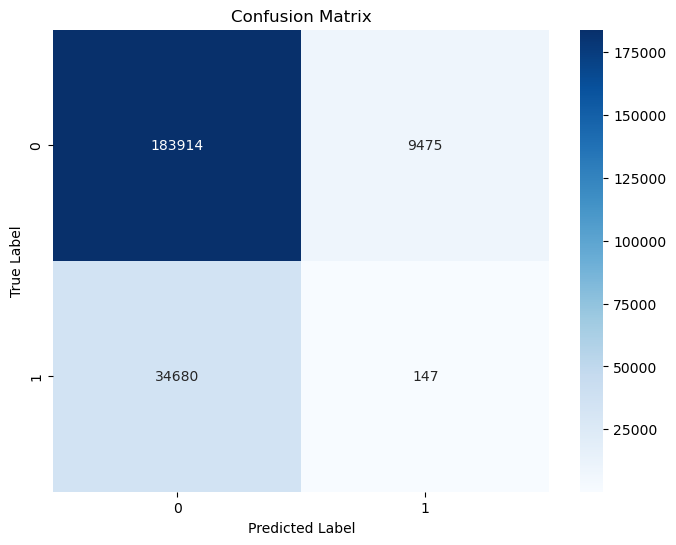

True Positives (TP): 147
True Negatives (TN): 183914
False Positives (FP): 9475
False Negatives (FN): 34680


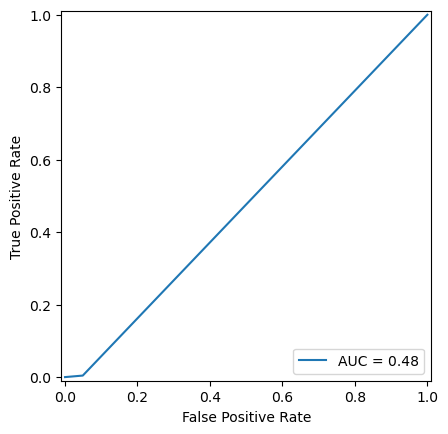

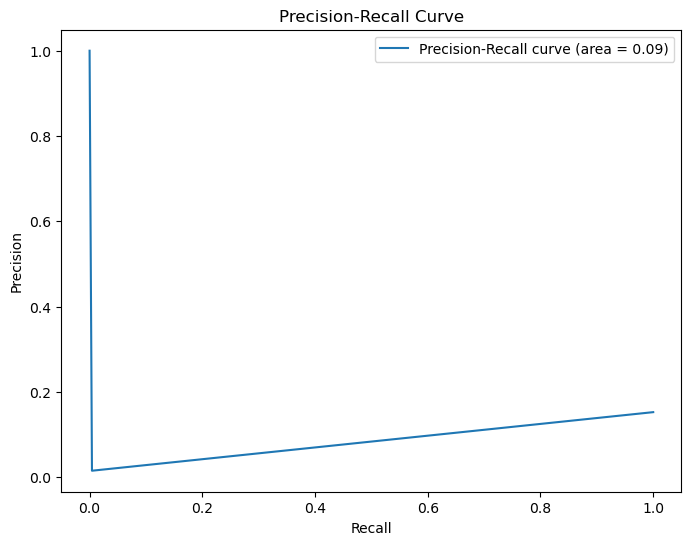

In [17]:
print_metrics(y_test,ypred_iforest)

## Local Outlier Factor

In [18]:
lof = LocalOutlierFactor(contamination=0.05, novelty=True)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.05, novelty=True)

In [19]:
predicted_scores = lof.decision_function(X_test)
predicted_labels = lof.predict(X_test)
predicted_labels = (predicted_labels == -1).astype(int)

c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    193389
           1       0.99      0.94      0.97     34827

    accuracy                           0.99    228216
   macro avg       0.99      0.97      0.98    228216
weighted avg       0.99      0.99      0.99    228216

Accuracy:	0.991
Precision:	0.9906884072849632
Recall:		0.991
F1-Score:	0.991
Average Precision Score: 0.9473321039271764
Balanced Accuracy Score: 0.971519568438
Matthews Correlation Coefficient (MCC): 0.9635453645618689
AUC : 0.97152


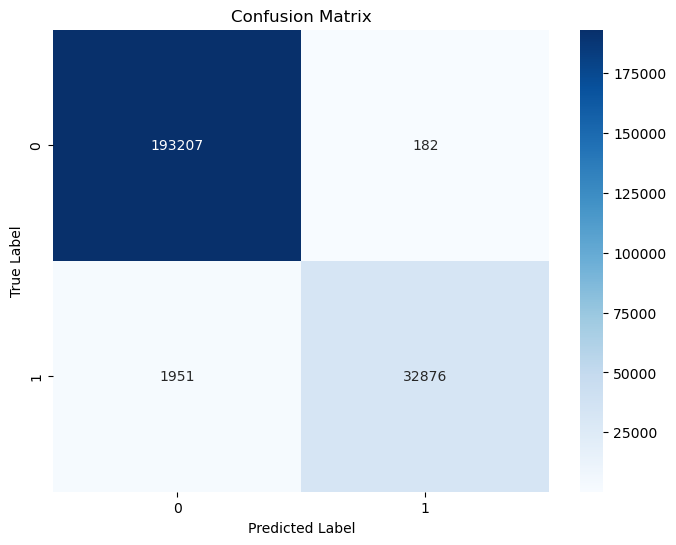

True Positives (TP): 32876
True Negatives (TN): 193207
False Positives (FP): 182
False Negatives (FN): 1951


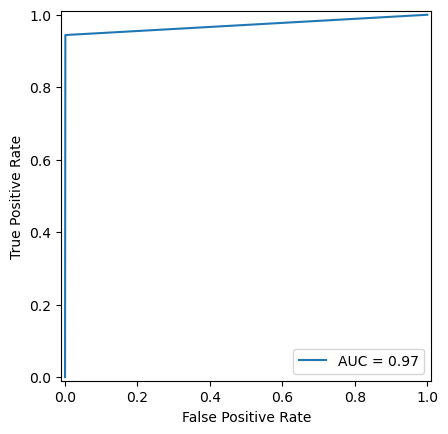

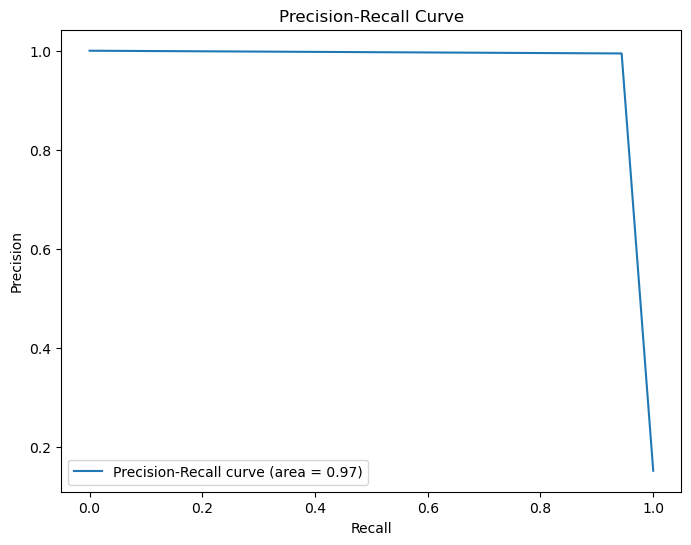

In [20]:
print(classification_report(y_test, predicted_labels))
print_metrics(y_test,predicted_labels)

## SVM

In [21]:
model = linear_model.SGDOneClassSVM(random_state=0).fit(X_train)

              precision    recall  f1-score   support

           0       0.80      0.71      0.75    193389
           1       0.02      0.04      0.03     34827

    accuracy                           0.61    228216
   macro avg       0.41      0.37      0.39    228216
weighted avg       0.68      0.61      0.64    228216

Accuracy:	0.609
Precision:	0.6849833555113135
Recall:		0.609
F1-Score:	0.644
Average Precision Score: 0.14767852060261066
Balanced Accuracy Score: 0.3747035121645893
Matthews Correlation Coefficient (MCC): -0.20799376300519612
AUC : 0.37470


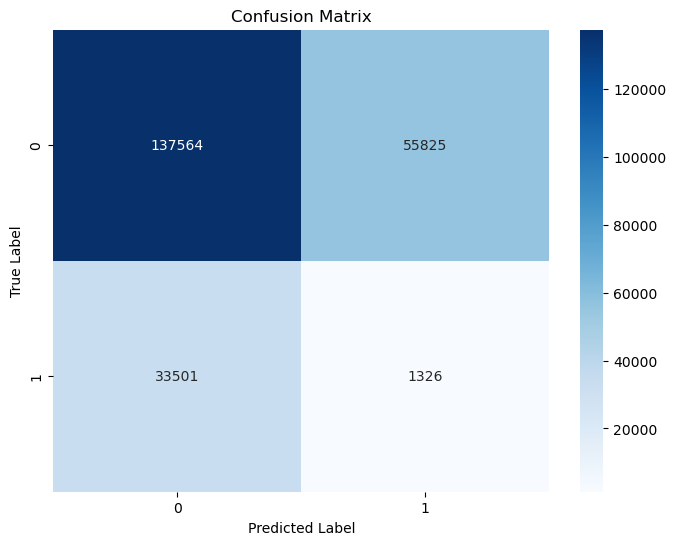

True Positives (TP): 1326
True Negatives (TN): 137564
False Positives (FP): 55825
False Negatives (FN): 33501


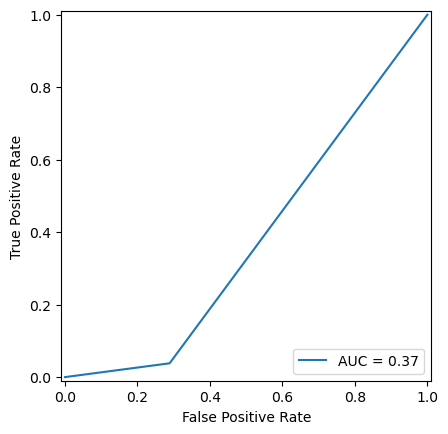

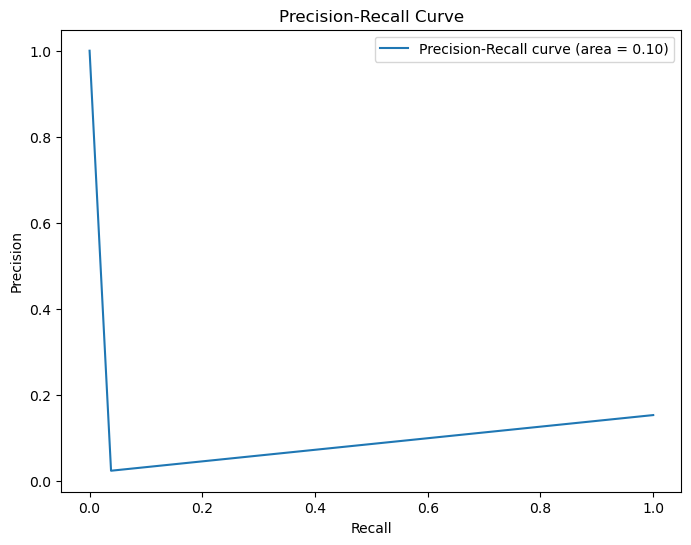

In [22]:
y_pred_svm = model.predict(X_test)
y_pred_svm = prepare_labels(y_pred_svm)
print(classification_report(y_test,y_pred_svm))
print_metrics(y_test,y_pred_svm)

## Autoenconder

In [23]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

input_dim = X_train.shape[1] # Number of features

# Encoder
input_layer = Input(shape=(input_dim, ))
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)

# Bottleneck
bottleneck = Dense(32, activation="relu")(encoder)

# Decoder
decoder = Dense(64, activation="relu")(bottleneck)
decoder = Dense(128, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [24]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("best_weights.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_test, X_test),
    shuffle=True,
    callbacks=[checkpoint]
)
autoencoder.load_weights("best_weights.keras")

Epoch 1/20
3012/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 523.1586
Epoch 1: val_loss improved from inf to 0.03890, saving model to best_weights.keras
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 521.1372 - val_loss: 0.0389
Epoch 2/20
2996/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0562
Epoch 2: val_loss did not improve from 0.03890
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0569 - val_loss: 4.2455
Epoch 3/20
2996/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2061
Epoch 3: val_loss did not improve from 0.03890
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2057 - val_loss: 0.0626
Epoch 4/20
2995/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1863
Epoch 4: val_loss did not improve from 0.03890
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1863 - val_loss: 0.1232
Epoch 5/20
2987/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1778
Epoch 5: val_loss did not improve from 0.03890
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1778 - val_loss: 0.

In [25]:
# Predict on the test set
X_test_pred = autoencoder.predict(X_test)

X_train_pred = autoencoder.predict(X_train)

7132/7132 ━━━━━━━━━━━━━━━━━━━━ 6s 790us/step
24193/24193 ━━━━━━━━━━━━━━━━━━━━ 17s 701us/step


In [26]:
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

In [27]:

threshold = np.quantile(mse_train, 0.99)

# Predict anomalies on the test set
y_pred_test = (mse_test > threshold)
y_pred_test = y_pred_test.astype(int)

In [28]:
from sklearn.metrics import classification_report, roc_auc_score

# Calculate classification metrics
print(classification_report(y_test, y_pred_test))

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_test) # Using raw MSE scores for AUC calculation
print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    193389
           1       0.95      0.95      0.95     34827

    accuracy                           0.98    228216
   macro avg       0.97      0.97      0.97    228216
weighted avg       0.98      0.98      0.98    228216

AUC-ROC: 0.97


Accuracy:	0.985
Precision:	0.9848802431316963
Recall:		0.985
F1-Score:	0.985
Average Precision Score: 0.9111527680499011
Balanced Accuracy Score: 0.9701141915319171
Matthews Correlation Coefficient (MCC): 0.9415380667296505
AUC : 0.97011


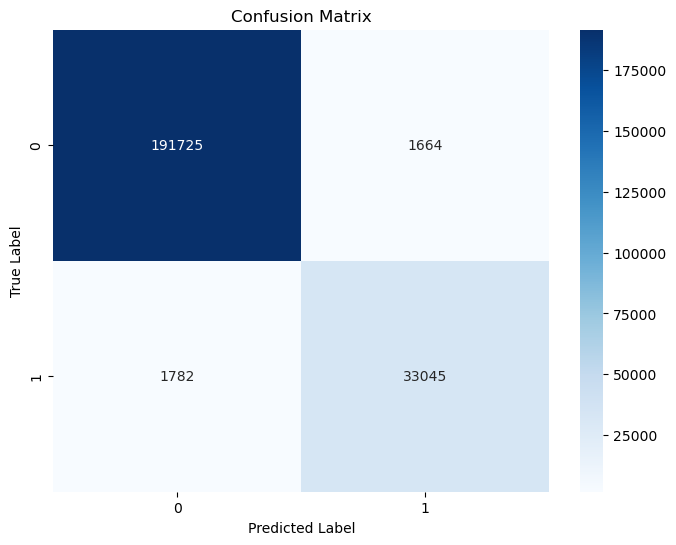

True Positives (TP): 33045
True Negatives (TN): 191725
False Positives (FP): 1664
False Negatives (FN): 1782


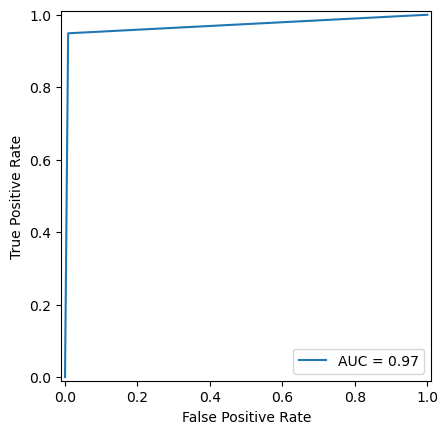

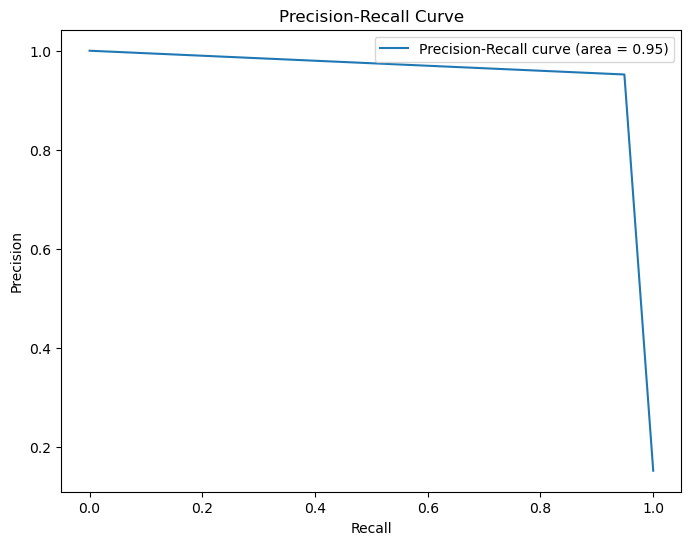

In [29]:
print_metrics(y_test,y_pred_test)